##**Image** **Similarity**

Given a set of images, in order to find the similar images to a given image, we first embed each image into a high-order vector. This vector holds the characteristics of the image, making it more class-specific. Then, we can use cosine similarity to calculate similarity ratios between images.

A similar project I worked on: https://www.researchgate.net/publication/345998768_Foreseeing_Brain_Graph_Evolution_over_Time_Using_Deep_Adversarial_Network_Normalizer

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 38.4 MB/s eta 0:00:00


We create a dataset class to read the export file, obtain images and their object images (cropped images)

In [ ]:
from PIL import Image
import requests
import json
import io


class ImageSimilarityDataset():
    def __init__(self, json_path, transform):
        self.samples = json.load(open(json_path, encoding="utf8"))
        self.transform = transform

    def __getitem__(self, idx):
        item = self.samples[idx]
        url = item["asset"]

        try:
            img = Image.open(io.BytesIO(requests.get(url).content))
        except:
            return None

        objects = item["tasks"][0]["objects"]
        objectImages = []
        for object in objects:
            # handle bounding box coordinates
            if object["bounding-box"]["height"] < 0:
                y1 = object["bounding-box"]["y"] + object["bounding-box"]["height"]
                y2 = object["bounding-box"]["y"]
            else:
                y1 = object["bounding-box"]["y"]
                y2 = object["bounding-box"]["y"] + object["bounding-box"]["height"]

            if object["bounding-box"]["width"] < 0:
                x1 = object["bounding-box"]["x"] + object["bounding-box"]["width"]
                x2 = object["bounding-box"]["x"]
            else:
                x1 = object["bounding-box"]["x"]
                x2 = object["bounding-box"]["x"] + object["bounding-box"]["width"]

            bbox = (x1, y1, x2, y2)
            objImg = img.crop(bbox)
            objImg = self.transform(objImg)
            objectImages.append(objImg)

        return objectImages

To embed the images into low-dimensional feature space, we use AutoModel of transformers. We obtain the embeddings from the last hidden space of Vision Transformer (ViT) model.

In [ ]:
from transformers import AutoModel
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model_ckpt = "google/vit-base-patch16-224"

model = AutoModel.from_pretrained(model_ckpt)
model = model.to(device)
hiddenDim = model.config.hidden_size
print(hiddenDim)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


768


To be able to read "export.json", we must upload the file from the left panel.

In [ ]:
import torchvision.transforms as T

transform = T.Compose(
    [
        T.Resize((224, 224)),
        T.ToTensor(),
    ])

imageDataset = ImageSimilarityDataset("export.json", transform)

We create an embed function that embeds each cropped image using the ViT model, stores the main image index and the index of the cropped image within that main image.

In [ ]:
import torch

def embed_images(model, dataset):
    # Vision Transformer model's hidden_dim is 786
    embeddings = torch.empty((786,))
    numCroppedImgs = 0
    imageNum = 0
    idxUrlMap = {}

    device = model.device
    for imgs in dataset:
        """print(numCroppedImgs)
        if numCroppedImgs > 5000:
            break"""
        # some images in "export.json" are not reachable so we check if the request is successful or not
        if imgs and imgs[0].shape[0] == 3:
                with torch.no_grad():
                    if numCroppedImgs == 0:
                        embeddings = model(torch.stack(imgs).to(device)).last_hidden_state[:, 0].cpu()
                    else:
                        embeddings = torch.cat((embeddings, model(torch.stack(imgs).to(device)).last_hidden_state[:, 0].cpu()), 0)

                    # store the index of the whole image and the cropped image
                    for idx in range(len(imgs)):
                        idxUrlMap[numCroppedImgs + idx] = [imageNum, idx]
                    numCroppedImgs += len(imgs)
        imageNum += 1

    return embeddings, idxUrlMap

In [ ]:
embeddings, idxMap = embed_images(model, imageDataset)

0
0
0
6
8
9
11
13
15
17
19
21
22
23
24
29
30
33
34
40
41
42
44
48
49
50
51
52
53
57
58
59
61
68
69
70
71
78
79
82
88
89
90
91
92
93
96
97
98
100
101
102
103
104
105
106
107
108
109
113
115
118
119
122
123
124
125
128
129
130
133
136
138
140
144
146
147
148
149
150
154
155
156
157
158
163
165
166
167
170
174
178
179
180
181
182
185
189
194
197
199
201
203
204
207
209
211
212
213
214
217
218
219
220
223
224
230
231
233
235
239
240
244
248
249
250
255
260
261
265
268
269
271
272
279
281
282
284
285
289
292
293
298
300
305
306
308
311
312
313
315
316
317
318
319
320
324
327
328
330
331
332
333
334
338
340
341
342
343
345
346
347
348
351
352
353
356
357
358
359
360
365
366
371
372
373
373
379
386
390
394
396
397
400
401
405
406
407
409
410
412
413
414
419
420
421
425
425
428
431
432
433
434
437
443
446
447
449
453
454
455
457
458
464
465
474
477
478
479
481
487
489
490
493
497
498
500
504
505
506
507
510
513
514
515
518
519
520
521
524
526
527
531
534
535
536
537
538
540
544
546
547
551
552

In [ ]:
from scipy.spatial import distance
import numpy as np

def compute_cosine_similarity(embedding, embeddings, dataset, idxMap):
    distances = distance.cdist(embedding.detach().numpy(), embeddings.detach().numpy(), "cosine")[0]
    minIndices = np.argsort(distances)[:12]
    print(minIndices)
    #similarImgs = [dataset[idxMap[minIndex][0]][0][idxMap[minIndex][1]] for minIndex in minIndices]

    similarImgs = []
    for minIndex in minIndices:
        imgs = dataset[idxMap[minIndex][0]] # the main image index
        similarImgs.append(imgs[idxMap[minIndex][1]]) # cropped image index

    return similarImgs


In [ ]:
from google.colab.patches import cv2_imshow
import cv2

def torch_to_cv2show(img):
    # Convert the tensor to a numpy array
    numpy_image = np.array(img)

    # Convert the numpy array to a cv2 image
    cv2_image = np.transpose(numpy_image, (1, 2, 0))
    #plt.imshow(cv2_image)
    cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)

    #(cv2_image)
    return cv2_image

In [ ]:
def plot_images(images):
    plt.figure(figsize=(20, 15))

    columns = 13
    for (i, image) in enumerate(images):
        ax = plt.subplot(len(images) // columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Selected Image")
        else:
            ax.set_title(str(i))
        plt.imshow(np.array(image).astype("int"))
        plt.axis("off")

Random image:  714
[1569  990 2453 3430 3484 1818   97  923 3809 4250 2644 1316]
Random image:  255
[ 535 3290  983 2060 4234 1841 3323  991 2372 2166 1985 3438]
Random image:  4815
[3469 3468 3277 3109  177  443 1481 2794 2862 3739 1270 1464]
Random image:  339
[ 714 1744 3137 1547 3975  711  710 1991 1270 1482 4905 2910]
Random image:  207
[ 507 3798  544 2498 3821  158 1780 1856 3875 3294 3921  249]
Random image:  4268
[4616 4615 1410 1902 4617 1409  322 4830 3053 1526 4423 3515]
Random image:  2366
[4752 4584 2032 4703 2866 2462 1886 1878 3524 3525 3507 4237]
Random image:  4390
[ 117 4435 3719  359  646  169 3552 3353 2795 4445  281 2068]
Random image:  1410
[2797 4686 4347 4685 2845 2798 4647 4169 1054 4523 1262 2878]
Random image:  3719
[ 826 2772  123 4461  842  505 3986 1747  239  217 1831  681]


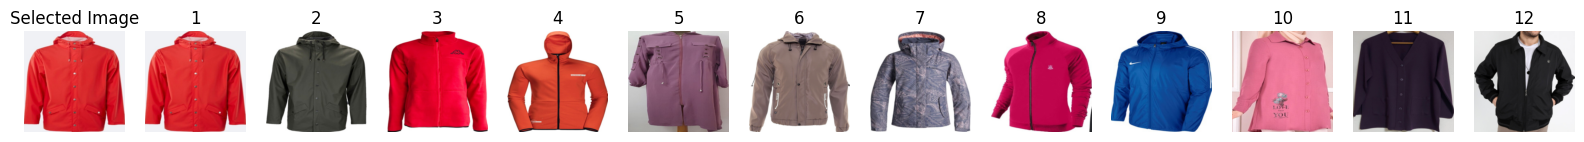

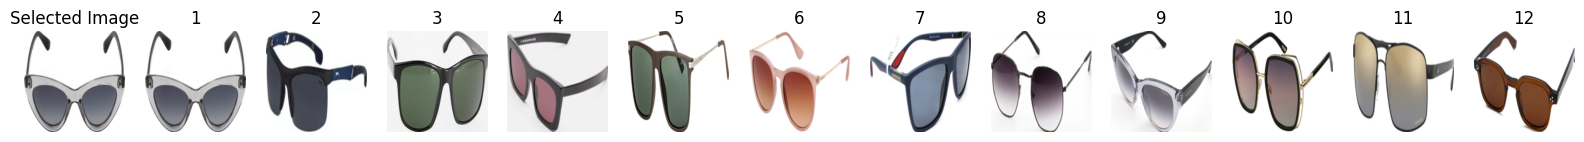

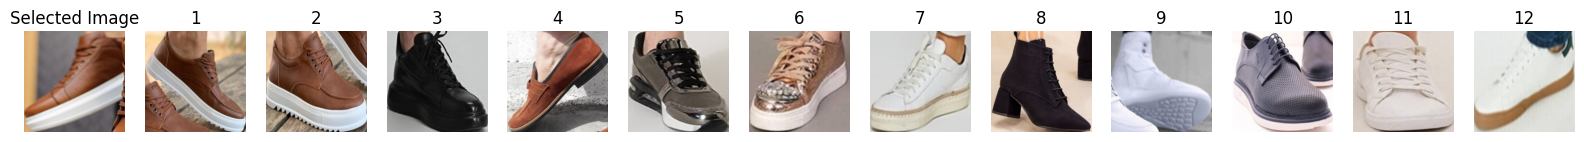

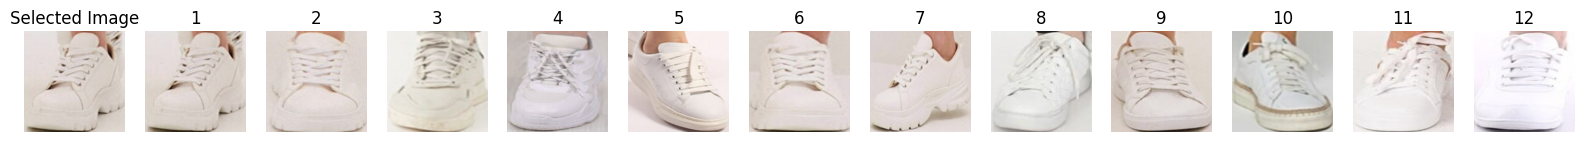

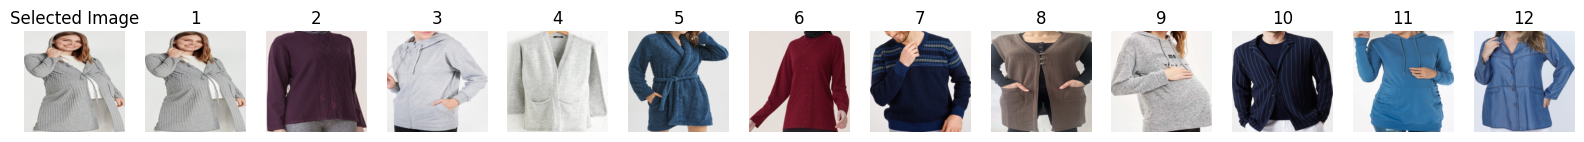

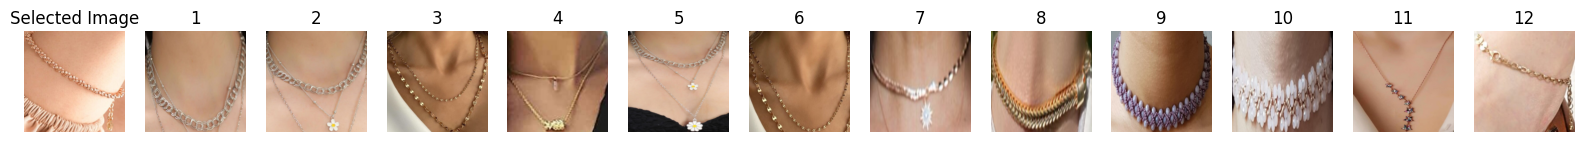

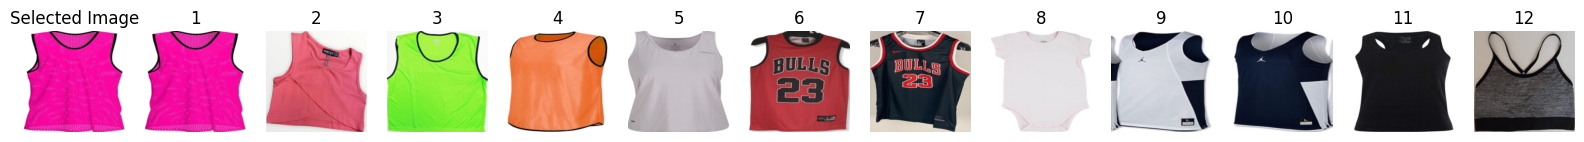

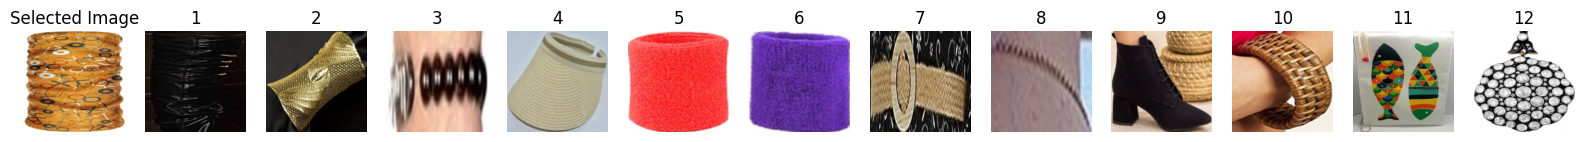

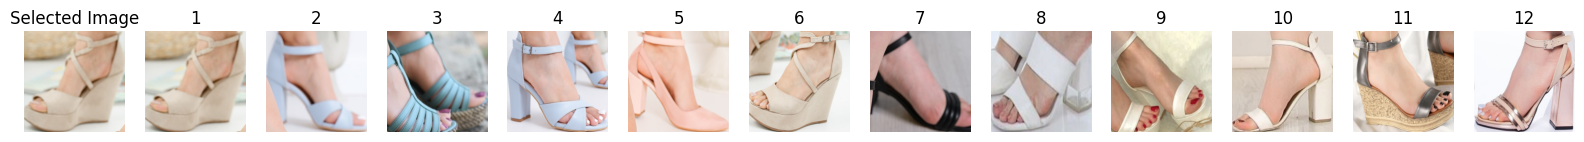

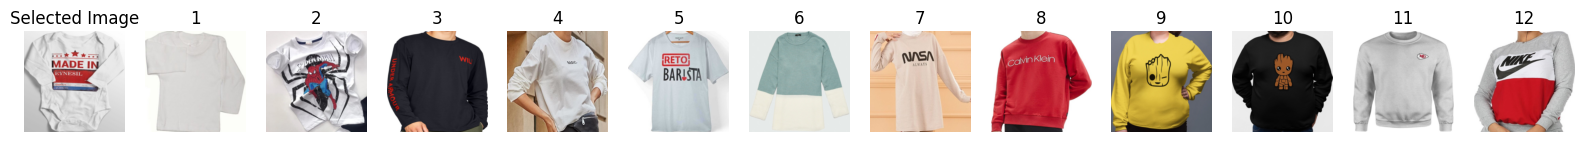

In [ ]:
import random
import matplotlib.pyplot as plt

# compute a list of random numbers
randomIndices = random.sample(range(0, 20000), 10)

toPil = T.ToPILImage()

for i in randomIndices:
    imgs = imageDataset[i]
    if not imgs:
        imgs = imageDataset[random.randint(0, 20000)]
    # image may have multiple cropped images so randomly select one
    idx = random.randrange(0, len(imgs))
    print("Random image: ", i + 1)

    images = [toPil(imgs[idx])]
    #display(toPil(imgs[idx]))

    # embed image
    device = model.device
    embedding = model(torch.unsqueeze(imgs[idx], 0).to(device)).last_hidden_state[:, 0].cpu()

    similarImages = compute_cosine_similarity(embedding, embeddings, imageDataset, idxMap)
    [images.append(toPil(img)) for img in similarImages]
    #display(*images)

    plot_images(images)